# Basic Models Experiments

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Import data 

In [1]:
# Import 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import skopt


# Pre Processing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


# Balancing Classes
from sklearn.utils.class_weight import compute_class_weight

# Metrics
from sklearn.metrics import *

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

#Hyper para
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Warnings
from sklearn.utils._testing import ignore_warnings

import warnings
warnings.filterwarnings('ignore')



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 50)


# MLP

from tensorflow import keras
import tensorflow as tf


In [2]:
# df festures dtypes
df_dtypes = {"PAYMENT_DAY":"category", "APPLICATION_SUBMISSION_TYPE":"category", "POSTAL_ADDRESS_TYPE":"category", "SEX":"category", "MARITAL_STATUS":"category",
             "STATE_OF_BIRTH":"category", "CITY_OF_BIRTH":"category", "NACIONALITY":"category",	"RESIDENCIAL_STATE":"category","RESIDENCIAL_CITY":"category",
             "RESIDENCIAL_BOROUGH":"category", "FLAG_RESIDENCIAL_PHONE":"category", "RESIDENCIAL_PHONE_AREA_CODE":"category", "RESIDENCE_TYPE":"category",
             "FLAG_EMAIL":"category", "FLAG_VISA":"category", "FLAG_MASTERCARD":"category",	"FLAG_DINERS":"category","FLAG_AMERICAN_EXPRESS":"category","FLAG_OTHER_CARDS":"category", 
             "QUANT_BANKING_ACCOUNTS":"category","QUANT_SPECIAL_BANKING_ACCOUNTS":"category","QUANT_CARS":"category","COMPANY":"category",
             "PROFESSIONAL_STATE":"category","FLAG_PROFESSIONAL_PHONE":"category","PROFESSIONAL_PHONE_AREA_CODE":"category","PROFESSION_CODE":"category","OCCUPATION_TYPE":"category",
             "PRODUCT":"category","RESIDENCIAL_ZIP_3":"category","PROFESSIONAL_ZIP_3":"category", "QUANT_DEPENDANTS":"category","AGE":"float64","total_cards" : "category", "TARGET_LABEL_BAD=1":"object",
             "MONTHS_IN_RESIDENCE":"category", "PERSONAL_MONTHLY_INCOME":"float", "OTHER_INCOMES":"category", "MONTHS_IN_THE_JOB":"category","PERSONAL_ASSETS_VALUE":"category"}

In [3]:
#Import DF
df = pd.read_csv(r"C:\Users\59898\Desktop\proyect\model\data\Clean_data\data01.csv",  encoding = "ISO-8859-1", sep = ",", dtype=df_dtypes, index_col = 0)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Split Data and Pipelines

In [4]:
# Mask to categorical and numeric columns
numerical_mask = (df.dtypes == "float64")
categorical_mask = (df.dtypes == "category")

# List with cat and num cols
numeric_cols  = df.columns[numerical_mask].tolist()
categorical_cols = df.columns[categorical_mask].tolist()

In [5]:
# Random Seed
seed = 123

# Split data into label and features
X = df.loc[:, df.columns != 'TARGET_LABEL_BAD=1']
y = df["TARGET_LABEL_BAD=1"].astype("int64")

# Train / test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = seed, stratify = y)
# Validation / Train Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = seed, stratify = y_train)

In [6]:
# Processing pipeline
num_transformer = Pipeline(
                            steps = [
                                        ("inputer", SimpleImputer(missing_values= np.nan,
                                                                  strategy = "median")),
                                        ("scaler", RobustScaler())
                                    ])
cat_transformer = Pipeline(
                            steps = [
                                        ("cat_inputer", SimpleImputer(missing_values= np.nan,
                                                                      strategy = "most_frequent")),
                                        ("encoder", OneHotEncoder(drop="if_binary",
                                                                  handle_unknown="ignore",
                                                                  sparse=False))
                                    ])

# Ensemble Transformers
pre_processor = ColumnTransformer(
                            transformers= [
                                        ("num", num_transformer, numeric_cols),
                                        ("cat", cat_transformer, categorical_cols)
                                        ],
                            verbose_feature_names_out = False)

In [7]:
# Apply  preprocessor to cat and num cols

# Train
X_pre_train = pre_processor.fit_transform(X= X_train)

# Validation
X_pre_val = pre_processor.transform(X=X_val)

# Test
X_pre_test = pre_processor.transform(X=X_test)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Evaluation tools

In [8]:
# Functions to evaluate models

def get_performance(predictions, y_test, classes=[0, 1]):
    
    report = classification_report(y_test, predictions, labels = classes, output_dict = True)
    
    return report


def plot_roc(model, y_test, features):
    # Put your code
    y_pred_probs = model.predict_proba(features)
    y_pred = y_pred_probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred)
    roc_auc = roc_auc_score(y_test,  y_pred)

    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})', linewidth=2.5)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#  Models

We have to balance the class weights to get substantial information because all the models are behaving the same way due to the data imbalance.

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
# Base models
classifiers = {             "RFB" : BalancedRandomForestClassifier(random_state = seed, n_estimators=100, class_weight = "balanced"),
                            "SGD" : SGDClassifier(class_weight="balanced", random_state = seed, loss = "log_loss", verbose = 0, max_iter  =100),
                            "XGB" : xgb.XGBClassifier( objective =  "binary:logistic", scale_pos_weight = 3, seed = seed, n_estimators =100),
                            "CB" : CatBoostClassifier( loss_function='Logloss', random_seed = seed, silent = True, class_weights= {0: 0.676439463177642, 1: 1.9169165757906217}, num_boost_round = 100),
                            "LGBM" : lgb.LGBMClassifier( class_weight = "balanced", random_state = seed, objective = "binary",   n_estimators=100), 
                            "ET" : ExtraTreesClassifier(random_state=seed, n_estimators=100, class_weight = "balanced"),

}

In [10]:
# AUC score in train
for  classifier in classifiers:
        
    steps = [('model', classifiers[classifier])]

    pipeline = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
    scores = cross_val_score(pipeline, X_pre_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    
    
    print("ROC-AUC Score for", classifier, round(np.mean(scores),5))

ROC-AUC Score for RFB 0.62131
ROC-AUC Score for SGD 0.62574
ROC-AUC Score for XGB 0.61868
ROC-AUC Score for CB 0.62383
ROC-AUC Score for LGBM 0.63547
ROC-AUC Score for ET 0.60503


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Validation AUC and Clasification Report of Models

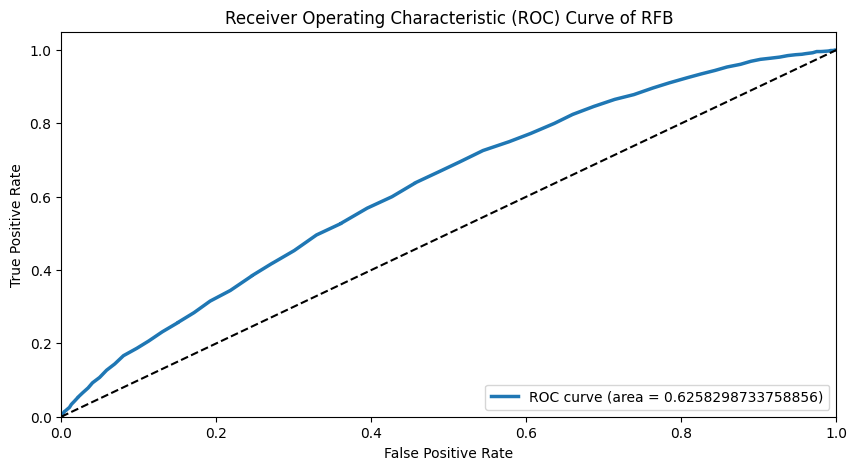

              precision    recall  f1-score   support

           0       0.80      0.57      0.67      6930
           1       0.33      0.60      0.43      2445

    accuracy                           0.58      9375
   macro avg       0.57      0.59      0.55      9375
weighted avg       0.68      0.58      0.61      9375



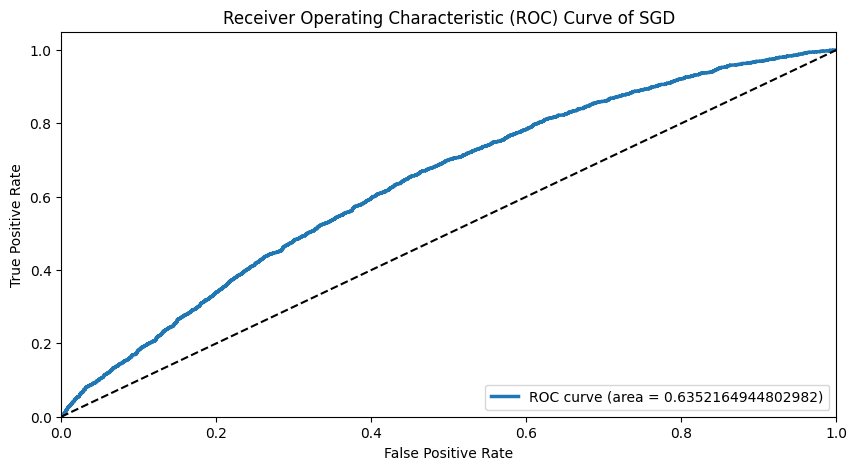

              precision    recall  f1-score   support

           0       0.79      0.72      0.75      6930
           1       0.36      0.45      0.40      2445

    accuracy                           0.65      9375
   macro avg       0.58      0.59      0.58      9375
weighted avg       0.68      0.65      0.66      9375



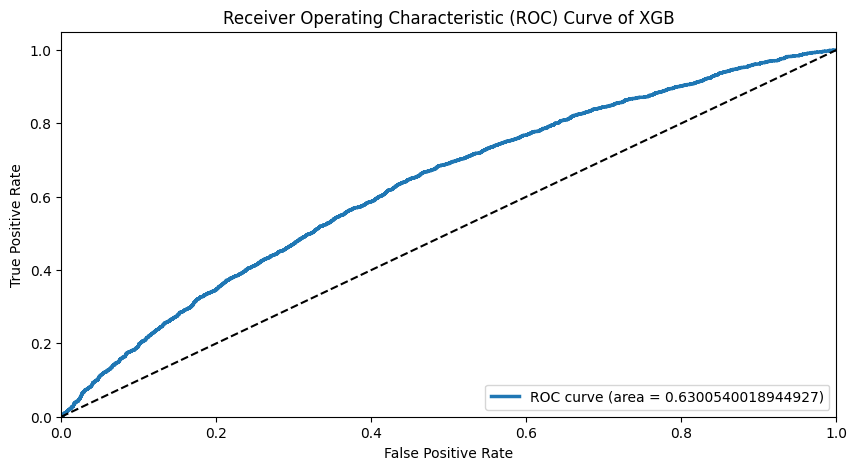

              precision    recall  f1-score   support

           0       0.80      0.62      0.70      6930
           1       0.34      0.57      0.43      2445

    accuracy                           0.60      9375
   macro avg       0.57      0.59      0.56      9375
weighted avg       0.68      0.60      0.63      9375



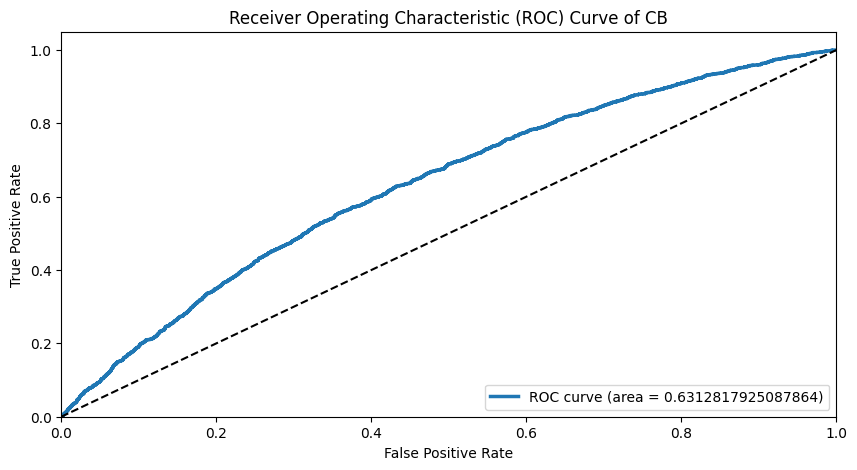

              precision    recall  f1-score   support

           0       0.80      0.62      0.70      6930
           1       0.35      0.57      0.43      2445

    accuracy                           0.61      9375
   macro avg       0.58      0.60      0.57      9375
weighted avg       0.69      0.61      0.63      9375



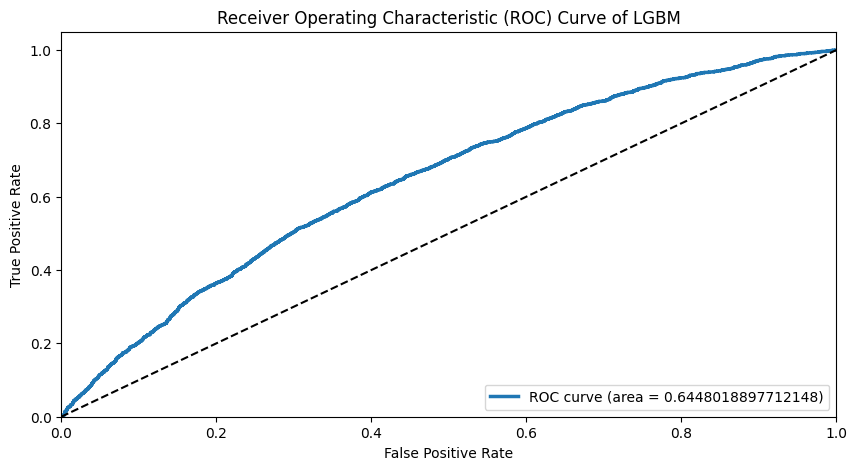

              precision    recall  f1-score   support

           0       0.81      0.61      0.70      6930
           1       0.35      0.60      0.44      2445

    accuracy                           0.61      9375
   macro avg       0.58      0.61      0.57      9375
weighted avg       0.69      0.61      0.63      9375



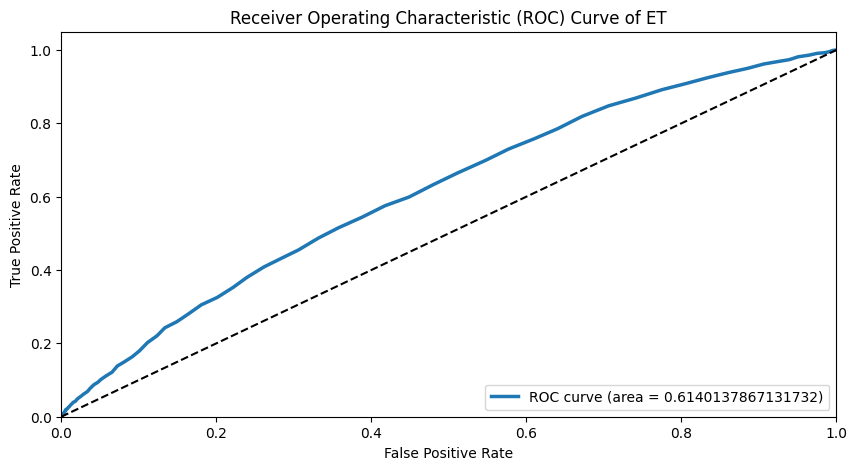

              precision    recall  f1-score   support

           0       0.75      0.96      0.84      6930
           1       0.42      0.08      0.13      2445

    accuracy                           0.73      9375
   macro avg       0.59      0.52      0.49      9375
weighted avg       0.66      0.73      0.66      9375



In [11]:
#  AUC score and Classification report of Models
reports = {}

for  classifier in classifiers:  
        
    steps = [('model', classifiers[classifier])]

    pipeline = Pipeline(steps=steps)

    pipeline.fit(X_pre_train, y_train)
    
    y_predict  = pipeline.predict(X_pre_val)
    
    y_pred_probs = pipeline.predict_proba(X_pre_val)
    
    y_pred = y_pred_probs[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_val,  y_pred)
    
    roc_auc = roc_auc_score(y_val,  y_pred)

    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})', linewidth=2.5)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"Receiver Operating Characteristic (ROC) Curve of {classifier}")
    plt.legend(loc="lower right")
    plt.show()
    print(classification_report(y_val, y_predict, labels = [0, 1]))
    

In [12]:
#MLP
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(352,)),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC'])

model.fit(X_pre_train, y_train, epochs=25, batch_size=16)
test_loss, test_acc = model.evaluate(X_pre_val, y_val)

Epoch 1/25
1758/1758 [==============================] - 3s 917us/step - loss: 0.5671 - auc: 0.5969
Epoch 2/25
1758/1758 [==============================] - 2s 920us/step - loss: 0.5491 - auc: 0.6438
Epoch 3/25
1758/1758 [==============================] - 2s 899us/step - loss: 0.5442 - auc: 0.6572
Epoch 4/25
1758/1758 [==============================] - 2s 961us/step - loss: 0.5404 - auc: 0.6651
Epoch 5/25
1758/1758 [==============================] - 2s 1ms/step - loss: 0.5380 - auc: 0.6710
Epoch 6/25
1758/1758 [==============================] - 2s 1ms/step - loss: 0.5357 - auc: 0.6758
Epoch 7/25
1758/1758 [==============================] - 2s 1ms/step - loss: 0.5334 - auc: 0.6807
Epoch 8/25
1758/1758 [==============================] - 2s 927us/step - loss: 0.5315 - auc: 0.6841
Epoch 9/25
1758/1758 [==============================] - 2s 915us/step - loss: 0.5299 - auc: 0.6876
Epoch 10/25
1758/1758 [==============================] - 2s 952us/step - loss: 0.5273 - auc: 0.6929
Epoch 11/25
175

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Hyperparameters Tuning

In [13]:
# import wandb
# wandb.login()

In [14]:
# def train_model(): XGB
#       # Set default configurations (Defaults will be overwritten during sweep)
#   config_defaults = {
      
#       'max_depth': 3, 
#       'min_child_weight': 1,
#       'n_estimators': 1500,
#       'learning_rate' : 0.3,
#       'colsample_bytree' : 0.3,
#       "subsample" : 0.3,
#       "reg_alpha" : 0,
#       "reg_lambda" : 0,
#       "objective" : "binary:logistic",
#       "random_state" : 123
      
#   }

#   # Start W&B
#   wandb.init(config=config_defaults)
#   config = wandb.config

#   # Fit regression model on train set
#   model = xgb.XGBClassifier(
#       max_depth=config.max_depth, 
#       min_child_weight=config.min_child_weight,
#       n_estimators=config.n_estimators,
#       learning_rate=config.learning_rate,
#       colsample_bytree=config.colsample_bytree,
#       subsample=config.subsample,
#       reg_alpha=config.reg_alpha,
#       reg_lambda=config.reg_lambda,
#       scale_pos_weight = 3,
#       objective=config.objective,
#       seed=config.random_state
#     )
  
#   model.fit(X_pre_train, y_train)
#   # Predict on test set
#   y_pred = model.predict_proba(X_pre_val)
#   y_pred_t = model.predict_proba(X_pre_test)
#   # Evaluate predictions
#   auc_val = roc_auc_score(y_val,  y_pred[:, 1])
#   auc_test = roc_auc_score(y_test,  y_pred_t[:, 1])
#   print(f"AUC: {round(auc_val, 4)}")

#   # Log model performance metrics to W&B
#   wandb.log({"auc_val": auc_val, "auc_test": auc_test})

In [15]:
# sweep_configs = { 
#     "method": "bayes",
#     "metric": {
#         "name": "auc_val",
#         "goal": "maximize"
#     },
#     "parameters": {
#         "max_depth": {
#             "values": [2,3,4]
#         },
#         "min_child_weight": {
#             "values": [0,3,5,7,10]
#         },
#         "n_estimators": {
#             "values": [5000,4000,3000]
        
#         },
#         'learning_rate' : {
#             "values" : [0.05, 0.025, 0.01, 0.005]
#         },
#         'colsample_bytree': {
#             "values" : [0.3, 0.5, 0.7, 0.9]
#         },
#         "subsample" : {
#             "values" : [0.3, 0.5, 0.7, 0.9]
#         },
#         "reg_alpha" : {
#             "values" : [0,1,2,3,4,5]
#         },
#         "reg_lambda" : {
#             "values" : [0,1,2,3,4,5]
#         },
#         "random_state"  : {
#             "values" : [123]
#         },
#         "objective" : {
#             "values" : ["binary:logistic"]
#         }
#     }}

In [16]:
# def train_model(): SGD
#       # Set default configurations (Defaults will be overwritten during sweep)
#   config_defaults = {
      
#       'n_estimators': 1500,
#       'learning_rate' : 0.1,
#       "penalty" : 0,
#       "random_state" : 123
      
#   }

#   # Start W&B
#   wandb.init(config=config_defaults)
#   config = wandb.config

#   # Fit regression model on train set
#   model = SGDClassifier(class_weight="balanced",
#                         random_state = config.random_state,
#                         loss = "log_loss",
#                         verbose = 0,
#                         max_iter  =config.n_estimators,
#                         penalty = config.penalty,
#                         alpha= config.learning_rate)
  
#   model.fit(X_pre_train, y_train)
#   # Predict on test set
#   y_pred = model.predict_proba(X_pre_val)
#   y_pred_t = model.predict_proba(X_pre_test)
#   # Evaluate predictions
#   auc_val = roc_auc_score(y_val,  y_pred[:, 1])
#   auc_test = roc_auc_score(y_test,  y_pred_t[:, 1])
#   print(f"AUC: {round(auc_val, 4)}")

#   # Log model performance metrics to W&B
#   wandb.log({"auc_val": auc_val, "auc_test": auc_test})

In [17]:
# sweep_configs = { SGD
#     "method": "bayes",
#     "metric": {
#         "name": "auc_val",
#         "goal": "maximize"
#     },
#     "parameters": {

#         "penalty": {
#             "values": ["l1", "l2"]
#         },
#         "n_estimators": {
#             "values": [3000, 2500, 2000, 1500]
        
#         },
#         'learning_rate' : {
#             "values" : [0.05, 0.025, 0.01, 0.005]
       
#         }
#     }}

In [18]:
# sweep_id = wandb.sweep(sweep=sweep_configs, project="credit")
# wandb.agent(sweep_id=sweep_id, function=train_model, count=200)

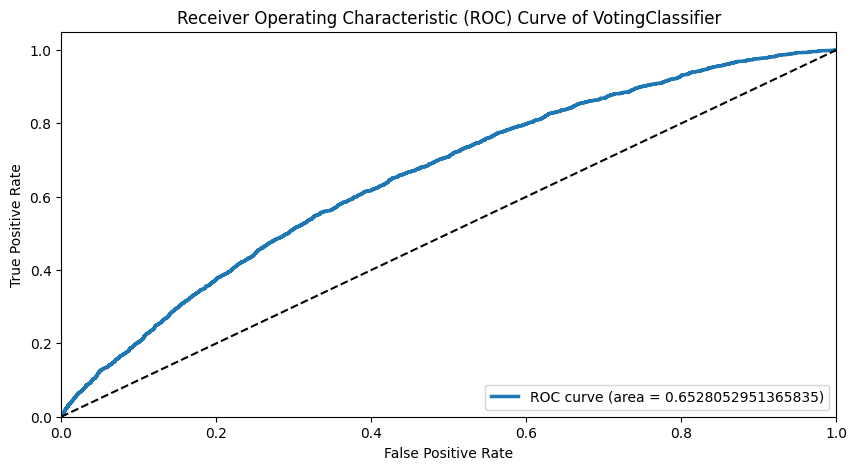

              precision    recall  f1-score   support

           0       0.82      0.58      0.68      6930
           1       0.35      0.64      0.45      2445

    accuracy                           0.60      9375
   macro avg       0.58      0.61      0.57      9375
weighted avg       0.70      0.60      0.62      9375



In [19]:
xgb_cl = xgb.XGBClassifier(scale_pos_weight = 3,
                           seed = 123,
                           objective = "binary:logistic",
                           n_estimators = 5000,
                           max_depth = 4,
                           colsample_bytree = 0.5,
                           learning_rate = 0.005,
                           reg_alpha = 2,
                           reg_lambda = 5,
                           subsample = 0.7)

lgb_cl = lgb.LGBMClassifier(class_weight = "balanced",
                            random_state = seed,
                            objective = "binary",
                            n_estimators=3000,
                            max_depth = 3,
                            num_leaves = 220,
                            learning_rate = 0.025,
                            reg_alpha = 5,
                            reg_lambda = 2,
                            colsample_bytree=0.3,
                            )
vtcl = VotingClassifier(estimators=[('lgbm', lgb_cl), ('xgb', xgb_cl)], voting='soft')

vtcl.fit(X_pre_train, y_train)

y_preds = vtcl.predict_proba(X_pre_val)

y_predict = vtcl.predict(X_pre_val)

y_pred = y_preds[:, 1]
    
fpr, tpr, thresholds = roc_curve(y_val,  y_pred)

roc_auc = roc_auc_score(y_val,  y_pred)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})', linewidth=2.5)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"Receiver Operating Characteristic (ROC) Curve of VotingClassifier")
plt.legend(loc="lower right")
plt.show()
print(classification_report(y_val, y_predict, labels = [0, 1]))


In [20]:
from sklearn.ensemble import BaggingClassifier

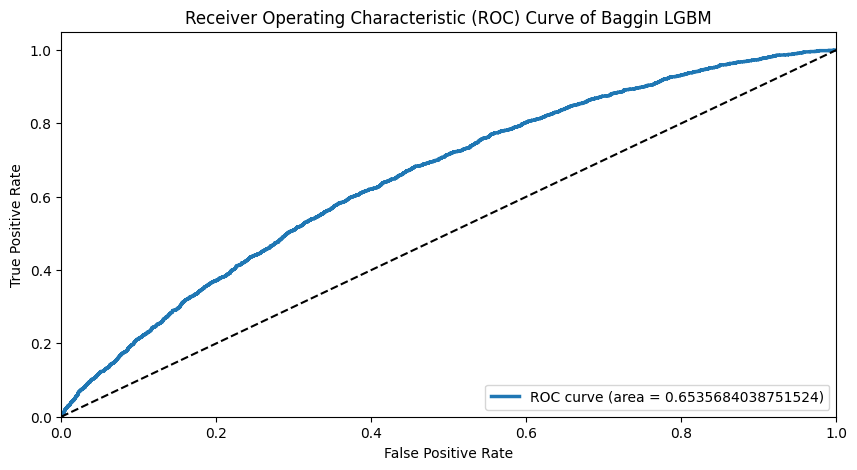

              precision    recall  f1-score   support

           0       0.82      0.62      0.71      6930
           1       0.36      0.60      0.45      2445

    accuracy                           0.62      9375
   macro avg       0.59      0.61      0.58      9375
weighted avg       0.70      0.62      0.64      9375



In [21]:
clf = BaggingClassifier(lgb_cl , n_estimators=50, random_state=0)
clf.fit(X_pre_train, y_train)

y_preds = clf.predict_proba(X_pre_val)

y_predict = clf.predict(X_pre_val)

y_pred = y_preds[:, 1]
    
fpr, tpr, thresholds = roc_curve(y_val,  y_pred)

roc_auc = roc_auc_score(y_val,  y_pred)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})', linewidth=2.5)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"Receiver Operating Characteristic (ROC) Curve of Baggin LGBM")
plt.legend(loc="lower right")
plt.show()
print(classification_report(y_val, y_predict, labels = [0, 1]))